## Задание

### Часть 1 (5 балла)
1. Выберите одну любую из задач, рассмотренных на [лекции](https://colab.research.google.com/drive/1B7Np_7y002NLiuNkriq6a6MchQL4Fw7p?usp=sharing) (локализация, сегментация, перенос стиля, генерация).

2. Подберите на kaggle датасет, подходящий для решения этой задачи.
  - Вариант 1: если данные обладают необходимой разметкой, то повторите пайплайн из блокнота с примером на своих данных.
  - Вариант 2: если данные не обладают необходимой разметкой, то используйте модель, которую дообучали в примере, но без дообучения.
3. Оцените и прокомментируйте результат.

### Часть 2 (8 баллов)
1. Выберите еще одну из рассмотренных в лекции задач (не совпадающую с первой).
2. Если ваши данные обладают разметкой, необходимой для новой задачи, продолжите работу с ними. Если нет, найдите другой датасет, в котором она будет. Можно взять какой-нибудь стандартный в PyTorch, но такой, который не встречался ни в одном из примеров с лекции. В этом задании обязательно нужно найти датасет с разметкой.
3. Повторите пайплайн из примера.
4. Постарайтесь улучшить качество результата (если классификация - точность выше 90%, во всех остальных - максимально понизить лосс). Это можно сделать за счет настройки гиперпараметров. Можно (опционально и в зависимости от задачи) также поменять гиперпараметры в слоях нейронных сетей и/или порядок слоев и/или их количество.

В заданиях, где перечислены два варианта выполнения, нужно выбрать только один. Выполнение обоих дополнительных баллов не дает.



## Куда сдавать?

По инструкции в гитхаб – https://shy-question-39d.notion.site/1150ea832e418032bfc3d3e827c380fb?pvs=74

- К этой работе тестов нет.
- Эту работу можно выполнить с кем-нибудь в паре или в гордом одиночестве.
- Пул-реквест нужно сделать в ветку `lab3`. Если вас двое, то можно 1 или 2 пул-реквеста, главное – отметьте как-нибудь, что выполняли в паре.

**Устная защита работ не требуется, но вам могут быть заданы вопросы прямо в вашем пул-реквесте!**

Часть 1 - Перенос стиля

In [26]:
# -*- coding: utf-8 -*-
"""PyTorch Neural Style Transfer.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1KaXfphPVD3eo3vJvTu8Cu2pUibgxF51D

## Neural Style Transfer

## Задача

Объединить две картинки, используя одну из них в качестве фильтра.
"""

# Установка необходимых библиотек
!pip install torch torchvision
!pip install kaggle

# Настройка Kaggle API для загрузки WikiArt Dataset
from google.colab import files
files.upload()  # Загрузите файл kaggle.json

!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d antoinegruson/-wikiart-all-images-120k-link
!unzip -q -o \-wikiart-all-images-120k-link.zip -d /content/wikiart/


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/antoinegruson/-wikiart-all-images-120k-link
License(s): ODbL-1.0
 92% 3.00M/3.27M [00:00<00:00, 5.54MB/s]
100% 3.27M/3.27M [00:00<00:00, 5.05MB/s]
error:  -fn or any combination of -c, -l, -p, -t, -u and -v options invalid
caution:  both -n and -o specified; ignoring -o
UnZip 6.00 of 20 April 2009, by Debian. Original by Info-ZIP.

Usage: unzip [-Z] [-opts[modifiers]] file[.zip] [list] [-x xlist] [-d exdir]
  Default action is to extract files in list, except those in xlist, to exdir;
  file[.zip] may be a wildcard.  -Z => ZipInfo mode ("unzip -Z" for usage).

  -p  extract files to pipe, no messages     -l  list files (short format)
  -f  freshen existing files, create none    -t  test compressed archive data
  -u  update files, create if necessary      -z  display archive comment only
  -v  list verbosely/show version info       -T  timestamp archive to latest
  -x  exclude files that follow (in xlist)   -

In [30]:
# Импорт библиотек
import torch
from torchvision import models
from torchvision import transforms as T
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import urllib.request
import os

# Загрузка предобученной VGG19
vgg = models.vgg19(pretrained=True).features
for parameters in vgg.parameters():
    parameters.requires_grad_(False)

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(dev)

# Проверка наличия файла CSV
import zipfile

# Путь к ZIP-файлу
zip_path = '/content/-wikiart-all-images-120k-link.zip'
extract_dir = '/content/wikiart/'

# Проверка наличия ZIP-файла и его распаковка
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
else:
    raise FileNotFoundError(f"Архив {zip_path} не найден. Убедитесь, что файл загружен.")

# Поиск файла CSV
csv_file = None
for root, dirs, files in os.walk(extract_dir):
    for file in files:
        if file == 'wikiart_scraped.csv':
            csv_file = os.path.join(root, file)
            break

if not csv_file:
    raise FileNotFoundError("Файл 'wikiart_scraped.csv' не найден в распакованной папке.")

print(f"Файл CSV найден: {csv_file}")

# Чтение CSV
wikiart = pd.read_csv(csv_file)

def download_image(url):
    url_response = urllib.request.urlopen(url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def preprocess_image(image, max_size=400):  # Размер из примера
    image = Image.fromarray(image)
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    img_transforms = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])
    image = img_transforms(image)
    image = image.unsqueeze(0)  # Добавление batch-size
    return image

# Выбор изображений
content_row = wikiart.sample()
style_row = wikiart.sample()

content_url = content_row.iloc[0]['Link']
style_url = style_row.iloc[0]['Link']

content_img = download_image(content_url)
style_img = download_image(style_url)

content_preprocess = preprocess_image(content_img).to(dev)
style_preprocess = preprocess_image(style_img).to(dev)

# Преобразование тензора в изображение
def deprocess(tensor):
    image = tensor.to("cpu").clone()
    image = image.numpy()
    image = image.squeeze(0)  # (1, 3, 224, 224) -> (3, 224, 224)
    image = image.transpose(1, 2, 0)  # (3, 224, 224) -> (224, 224, 3)
    image = image * np.array([0.485, 0.456, 0.406]) + np.array([0.229, 0.224, 0.225])
    image = image.clip(0, 1)
    return image

# Функция для извлечения признаков
def get_features(image, model):
    layers = {
        "0": "conv1_1",
        "5": "conv2_1",
        "10": "conv3_1",
        "19": "conv4_1",
        "21": "conv4_2",  # content feature
        "28": "conv5_1"
    }
    x = image
    features = {}
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# Матрица Грама
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

# Извлечение признаков
content_features = get_features(content_preprocess, vgg)
style_features = get_features(style_preprocess, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Стилизация (точно по примеру)
results = []

# Параметры
alpha = 1.0
beta = 1e5
epochs = 200
show_every = 50

# Копия изображения контента для стилизации
target = content_preprocess.clone().requires_grad_(True).to(dev)
optimizer = torch.optim.Adam([target], lr=0.003)

for i in range(epochs):
    # Извлечение признаков текущего изображения
    target_features = get_features(target, vgg)

    # Потери контента
    c_loss = torch.mean((target_features["conv4_2"] - content_features["conv4_2"]) ** 2)

    # Потери стиля
    s_loss = 0
    for layer in style_grams:
        target_gram = gram_matrix(target_features[layer])
        s_loss += torch.mean((target_gram - style_grams[layer]) ** 2)

    # Общая потеря
    t_loss = alpha * c_loss + beta * s_loss

    # Обратное распространение
    optimizer.zero_grad()
    t_loss.backward()
    optimizer.step()

    # Отображение прогресса
    if i % show_every == 0:
        print(f"Epoch {i}, Total Loss: {t_loss.item()}")
        results.append(deprocess(target.detach()))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Файл CSV найден: /content/wikiart/wikiart_scraped.csv
Epoch 0, Total Loss: 124731235762176.0
Epoch 50, Total Loss: 45697164378112.0
Epoch 100, Total Loss: 29155242541056.0
Epoch 150, Total Loss: 21037213286400.0


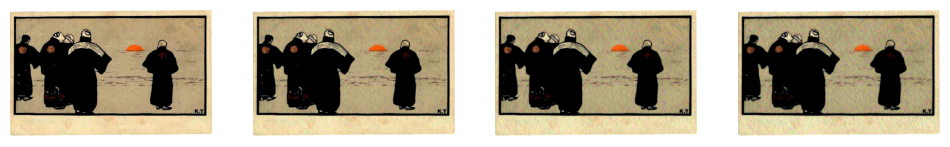

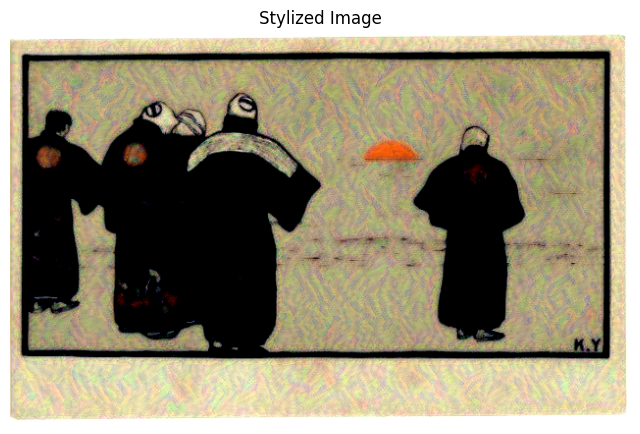

In [31]:
# Визуализация промежуточных результатов
plt.figure(figsize=(12, 8))
for idx, img in enumerate(results):
    plt.subplot(1, len(results), idx + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

# Финальное стилизованное изображение
final_img = deprocess(target.detach())
plt.figure(figsize=(8, 8))
plt.imshow(final_img)
plt.axis('off')
plt.title("Stylized Image")
plt.show()

За разумное время получается перенести стиль одного изображения на другое (особенно если оригинальное изображение не насыщено цветом). Для сокращения времени пришлось уменьшить максимальный размер изображения до 400 и сократить количество эпох до 200, таким образом получилось достичь вполне неплохого переноса стиля.

Часть 2 - Локализация

In [1]:
# -*- coding: utf-8 -*-
"""PyTorch Object Localization.ipynb

## Задача

Локализация объектов на основе Pascal VOC Dataset
"""

# Установка необходимых библиотек
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-680wh8ch
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-680wh8ch
  Resolved https://github.com/albumentations-team/albumentations to commit 1e7384ca23d027a60cc37d2198a64548a7746585
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 24.0 MB/s eta 0:00:00
  Created wheel for albumentations: filename=albumentations-1.4.23-py3-none-any.whl size=271503 sha256=14aacd1581a7bc7f5fbea0ae46d6d91514944b07d36655cba352474dde02faeb
  Stored in directory: /tmp/pip-ephem-wheel-cache-cdl5jt_s/wheels/51/4d/ab/5aafa8b980086fbc362946de7da4aa3df33aacb3da0da29b93
Successfully built albumentations
  Attempting uninstall: albu

In [2]:
# Импорт библиотек
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.transforms as T
import timm

# Настройка гиперпараметров
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 32  # Увеличение размера батча
img_size = 112  # Уменьшение размера изображений
lr = 0.001
epochs = 10
model_name = "efficientnet_b3"  # Более мощная архитектура
num_cor = 4
subset_size_train = 2000  # Увеличение размера тренировочного набора
subset_size_val = 200  # Увеличение размера валидационного набора

# Загрузка датасета Pascal VOC
from torchvision.datasets import VOCDetection

def collate_fn(batch):
    images, targets = [], []
    for b in batch:
        img, annot = b
        bbox = annot['annotation']['object'][0]['bndbox']
        xmin, ymin, xmax, ymax = map(int, [bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']])
        images.append(img)
        targets.append([xmin, ymin, xmax, ymax])
    return images, targets

transform = T.Compose([
    T.Resize((img_size, img_size)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor()
])

train_dataset = VOCDetection(root="/content", year="2007", image_set="train", download=True, transform=transform)
val_dataset = VOCDetection(root="/content", year="2007", image_set="val", download=True, transform=transform)

# Ограничение размеров датасетов
train_dataset = torch.utils.data.Subset(train_dataset, range(subset_size_train))
val_dataset = torch.utils.data.Subset(val_dataset, range(subset_size_val))

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=2, pin_memory=True)
validloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=True)

# Проверка загрузки данных
images, bboxes = next(iter(trainloader))
print(f"Shape of images: {[img.shape for img in images]}")
print(f"BBoxes: {bboxes[:5]}")

# Модель локализации объектов
class ObjectLocationModel(nn.Module):
    def __init__(self):
        super(ObjectLocationModel, self).__init__()
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=4)

    def forward(self, images, gt_bboxes=None):
        bboxes = self.backbone(images)
        if gt_bboxes is not None:
            loss = nn.MSELoss()(bboxes, gt_bboxes)
            return bboxes, loss
        return bboxes

model = ObjectLocationModel().to(device)

# Функции для обучения и валидации
def train_func(model, dataloader, optimizer):
    model.train()
    total_loss = 0.0
    for images, gt_bboxes in tqdm(dataloader):
        images = torch.stack([img.to(device) for img in images])
        gt_bboxes = torch.tensor(gt_bboxes, dtype=torch.float32).to(device)

        optimizer.zero_grad()
        bboxes, loss = model(images, gt_bboxes)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

def eval_func(model, dataloader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, gt_bboxes in tqdm(dataloader):
            images = torch.stack([img.to(device) for img in images])
            gt_bboxes = torch.tensor(gt_bboxes, dtype=torch.float32).to(device)
            bboxes, loss = model(images, gt_bboxes)
            total_loss += loss.item()
    return total_loss / len(dataloader)

# Обучение модели
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
best_valid_loss = float("inf")

for i in range(epochs):
    train_loss = train_func(model, trainloader, optimizer)
    val_loss = eval_func(model, validloader)

    if val_loss < best_valid_loss:
        torch.save(model.state_dict(), "best_model.pt")
        best_valid_loss = val_loss
        print("Model weights saved.")

    print(f"Epoch: {i+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

100%|██████████| 460M/460M [00:01<00:00, 237MB/s]


Extracting /content/VOCtrainval_06-Nov-2007.tar to /content
Using downloaded and verified file: /content/VOCtrainval_06-Nov-2007.tar
Extracting /content/VOCtrainval_06-Nov-2007.tar to /content
Shape of images: [torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.Size([3, 112, 112]), torch.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Model weights saved.
Epoch: 1/10, Train Loss: 42924.4712, Val Loss: 30781.8650


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


Model weights saved.
Epoch: 2/10, Train Loss: 25953.6007, Val Loss: 22219.4526


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


Model weights saved.
Epoch: 3/10, Train Loss: 17559.4483, Val Loss: 17016.4403


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Model weights saved.
Epoch: 4/10, Train Loss: 11797.4587, Val Loss: 11955.5527


100%|██████████| 7/7 [00:07<00:00,  1.12s/it]


Model weights saved.
Epoch: 5/10, Train Loss: 7928.1013, Val Loss: 10247.6618


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch: 6/10, Train Loss: 5665.5971, Val Loss: 11721.3809


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Model weights saved.
Epoch: 7/10, Train Loss: 4363.3046, Val Loss: 10209.4738


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 8/10, Train Loss: 3312.7691, Val Loss: 10609.6581


100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


Model weights saved.
Epoch: 9/10, Train Loss: 2487.1181, Val Loss: 9193.4439


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Model weights saved.
Epoch: 10/10, Train Loss: 1984.5283, Val Loss: 9092.5695


<ipython-input-25-8135b971e878>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt", map_location=device))


Original height: 112, width: 112
Predicted BBox: [65, 95, 111, 111]
Ground Truth BBox: [40, 71, 111, 111]


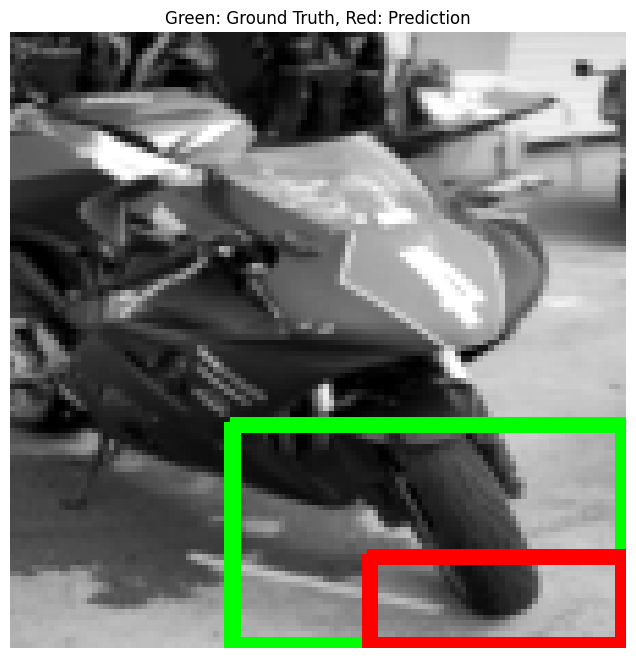

In [25]:
# Визуализация результатов
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.eval()

with torch.no_grad():
    images, gt_bboxes = next(iter(validloader))
    image = images[18].to(device).unsqueeze(0)  # (1, C, H, W)
    pred_bbox = model(image).cpu().squeeze().tolist()

    # Проверка оригинальных размеров
    height, width = images[18].shape[1:]
    print(f"Original height: {height}, width: {width}")

    # Ограничиваем координаты предсказанных рамок в пределах изображения
    pred_bbox = [
        max(0, min(int(pred_bbox[0] * width / img_size), width - 1)),
        max(0, min(int(pred_bbox[1] * height / img_size), height - 1)),
        max(0, min(int(pred_bbox[2] * width / img_size), width - 1)),
        max(0, min(int(pred_bbox[3] * height / img_size), height - 1)),
    ]

    # Истинные рамки
    gt_bbox = [
        max(0, min(gt_bboxes[18][0], width - 1)),
        max(0, min(gt_bboxes[18][1], height - 1)),
        max(0, min(gt_bboxes[18][2], width - 1)),
        max(0, min(gt_bboxes[18][3], height - 1)),
    ]

    # Отображение изображения с предсказанной и реальной рамкой
    img = images[18].permute(1, 2, 0).cpu().numpy()  # Преобразование к HWC
    img = np.ascontiguousarray((img * 255).clip(0, 255).astype(np.uint8))  # Приведение к uint8

    # Проверка предсказаний
    print(f"Predicted BBox: {pred_bbox}")
    print(f"Ground Truth BBox: {gt_bbox}")

    # Рисуем рамки
    img_with_boxes = img.copy()
    img_with_boxes = cv2.rectangle(img_with_boxes, tuple(gt_bbox[:2]), tuple(gt_bbox[2:]), (0, 255, 0), 2)  # Зеленая рамка
    img_with_boxes = cv2.rectangle(img_with_boxes, tuple(pred_bbox[:2]), tuple(pred_bbox[2:]), (255, 0, 0), 2)  # Красная рамка

    # Отображение изображения
    plt.figure(figsize=(8, 8))
    plt.imshow(img_with_boxes)
    plt.title("Green: Ground Truth, Red: Prediction")
    plt.axis("off")
    plt.show()

В обеих работах была применена более мощная архитектура, урезался размер изображения и ограничивалась выборка ради уменьшения времени обучения, и все равно во 2 части модель обучается достаточно долго и совсем неидеально локализует объекты, однако с некоторыми изображениями вполне справляется.